# Exercise

In this exercise, reproduce some of the findings from [What Makes Houston the Next Great American City? | Travel | Smithsonian](http://www.smithsonianmag.com/travel/what-makes-houston-the-next-great-american-city-4870584/), specifically the calculation represented in

![Alt text](http://thumbs.media.smithsonianmag.com//filer/Houston-diversity-3.jpg__600x0_q85_upscale.jpg "Optional title")

whose caption is

<blockquote>To assess the parity of the four major U.S. ethnic and racial groups, Rice University researchers used a scale called the Entropy Index. It ranges from 0 (a population has just one group) to 1 (all groups are equivalent). Edging New York for the most balanced diversity, Houston had an Entropy Index of 0.874 (orange bar).</blockquote>

The research report by *Smithsonian Magazine* is
[Houston Region Grows More Racially/Ethnically Diverse, With Small Declines in Segregation: A Joint Report Analyzing Census Data from 1990, 2000, and 2010](http://kinder.rice.edu/uploadedFiles/Urban_Research_Center/Media/Houston%20Region%20Grows%20More%20Ethnically%20Diverse%202-13.pdf) by the Kinder Institute for Urban Research & the Hobby Center for the Study of Texas.  

In the report, you'll find the following quotes:

<blockquote>How does Houston’s racial/ethnic diversity compare to the racial/ethnic
diversity of other large metropolitan areas? The Houston metropolitan
area is the most racially/ethnically diverse.</blockquote>

....

<blockquote>Houston is one of the most racially/ethnically diverse metropolitan
areas in the nation as well. *It is the most diverse of the 10 largest
U.S. metropolitan areas.* [emphasis mine] Unlike the other large metropolitan areas, all
four major racial/ethnic groups have substantial representation in
Houston with Latinos and Anglos occupying roughly equal shares of the
population.</blockquote>

....

<blockquote>Houston has the highest entropy score of the 10 largest metropolitan
areas, 0.874. New York is a close second with a score of 0.872.</blockquote>

....

Your task is:

1. Tabulate all the metropolian/micropolitan statistical areas.  Remember that you have to group various entities that show up separately in the Census API but which belong to the same area.  You should find 942 metropolitan/micropolitan statistical areas in the 2010 Census.

1. Calculate the normalized Shannon index (`entropy5`) using the categories of White, Black, Hispanic, Asian, and Other as outlined in the [Day_07_G_Calculating_Diversity notebook](http://nbviewer.ipython.org/github/rdhyee/working-open-data-2014/blob/master/notebooks/Day_07_G_Calculating_Diversity.ipynb#Converting-to-Racial-Dot-Map-Categories) 

1. Calculate the normalized Shannon index (`entropy4`) by not considering the Other category.  In other words, assume that the the total population is the sum of White, Black, Hispanic, and Asian.

1. Figure out how exactly the entropy score was calculated in the report from Rice University. Since you'll find that the entropy score reported matches neither `entropy5` nor `entropy4`, you'll need to play around with the entropy calculation to figure how to use 4 categories to get the score for Houston to come out to "0.874" and that for NYC to be "0.872".  [I **think** I've done so and get 0.873618 and 
0.872729 respectively.]

1. Add a calculation of the [Gini-Simpson diversity index](https://en.wikipedia.org/wiki/Diversity_index#Gini.E2.80.93Simpson_index) using the five categories of White, Black, Hispanic, Asian, and Other.

1. Note where the Bay Area stands in terms of the diversity index.

For bonus points:

* make a bar chart in the style used in the Smithsonian Magazine

Deliverable:

1. You will need to upload your notebook to a gist and render the notebook in nbviewer and then enter the nbviewer URL (e.g., http://nbviewer.ipython.org/gist/rdhyee/60b6c0b0aad7fd531938)
2. On bCourses, upload the CSV version of your `msas_df`.

# Hispanic or Latino Origin and Racial Subcategories

http://www.census.gov/developers/data/sf1.xml

compare to http://www.census.gov/prod/cen2010/briefs/c2010br-02.pdf 

I think the P0050001 might be the key category

* P0010001 = P0050001
* P0050001 = P0050002 + P0050010

P0050002 Not Hispanic or Latino (total) = 

* P0050003 Not Hispanic White only 
* P0050004 Not Hispanic Black only
* P0050006 Not Hispanic Asian only
* Not Hispanic Other (should also be P0050002 - (P0050003 + P0050004 + P0050006)
     * P0050005 Not Hispanic: American Indian/ American Indian and Alaska Native alone
     * P0050007 Not Hispanic: Native Hawaiian and Other Pacific Islander alone
     * P0050008 Not Hispanic: Some Other Race alone
     * P0050009 Not Hispanic: Two or More Races

* P0050010 Hispanic or Latino
  
P0050010 = P0050011...P0050017

From [Hispanic and Latino Americans (Wikipedia)](https://en.wikipedia.org/w/index.php?title=Hispanic_and_Latino_Americans&oldid=595018646):  

<blockquote>While the two terms are sometimes used interchangeably, Hispanic is a narrower term which mostly refers to persons of Spanish speaking origin or ancestry, while Latino is more frequently used to refer more generally to anyone of Latin American origin or ancestry, including Brazilians.</blockquote>

and

<blockquote>The Census Bureau's 2010 census does provide a definition of the terms Latino or Hispanic and is as follows: “Hispanic or Latino” refers to a person of Cuban, Mexican, Puerto Rican, South or Central American, or other Spanish culture or origin regardless of race. It allows respondents to self-define whether they were Latino or Hispanic and then identify their specific country or place of origin.[52] On its website, the Census Bureau defines "Hispanic" or "Latino" persons as being "persons who trace their origin [to]... Spanish speaking Central and South America countries, and other Spanish cultures".</blockquote>

In the [Racial Dot Map](http://bit.ly/rdotmap): "Whites are coded as blue; African-Americans, green; Asians, red; Hispanics, orange; and all other racial categories are coded as brown."  

In this notebook, we will relate the Racial Dot Map 5-category scheme to the P005\* variables.

In [1]:
%pylab --no-import-all inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, Series, Index
import pandas as pd

from itertools import islice

In [3]:
import census
import us

import settings

The census documentation has example URLs but needs your API key to work.  In this notebook, we'll use the IPython notebook HTML display mechanism to help out.


In [4]:
c = census.Census(key=settings.CENSUS_KEY)

In [5]:
# generators for the various census geographic entities of interest

def states(variables='NAME'):
    geo={'for':'state:*'}
    states_fips = set([state.fips for state in us.states.STATES])
    # need to filter out non-states
    for r in c.sf1.get(variables, geo=geo):
        if r['state'] in states_fips:
            yield r
            
def counties(variables='NAME'):
    """ask for all the states in one call"""
    
    # tabulate a set of fips codes for the states
    states_fips = set([s.fips for s in us.states.STATES])
    
    geo={'for':'county:*',
             'in':'state:*'}    
    for county in c.sf1.get(variables, geo=geo):
        # eliminate counties whose states aren't in a state or DC
        if county['state'] in states_fips:
            yield county
        

def counties2(variables='NAME'):
    """generator for all counties"""
    
    # since we can get all the counties in one call, 
    # this function is for demonstrating the use of walking through 
    # the states to get at the counties

    for state in us.states.STATES:
        geo={'for':'county:*',
             'in':'state:{fips}'.format(fips=state.fips)}
        for county in c.sf1.get(variables, geo=geo):
            yield county

            
def tracts(variables='NAME'):
    for state in us.states.STATES:
        
        # handy to print out state to monitor progress
        # print state.fips, state
        counties_in_state={'for':'county:*',
             'in':'state:{fips}'.format(fips=state.fips)}
        
        for county in c.sf1.get('NAME', geo=counties_in_state):
            
            # print county['state'], county['NAME']
            tracts_in_county = {'for':'tract:*',
              'in': 'state:{s_fips} county:{c_fips}'.format(s_fips=state.fips, 
                                                            c_fips=county['county'])}
            
            for tract in c.sf1.get(variables,geo=tracts_in_county):
                yield tract


def msas(variables="NAME"):
    
     for state in us.STATES:
        geo = {'for':'metropolitan statistical area/micropolitan statistical area:*', 
               'in':'state:{state_fips}'.format(state_fips=state.fips)
               }
    
        for msa in c.sf1.get(variables, geo=geo):
            yield msa
            
def block_groups(variables='NAME'):
    # http://api.census.gov/data/2010/sf1?get=P0010001&for=block+group:*&in=state:02+county:170
    # let's use the county generator
    for county in counties(variables):
        geo = {'for':'block group:*',
               'in':'state:{state} county:{county}'.format(state=county['state'],
                                                county=county['county'])
               }
        for block_group in c.sf1.get(variables, geo):
            yield block_group
    
    
def blocks(variables='NAME'):
    # http://api.census.gov/data/2010/sf1?get=P0010001&for=block:*&in=state:02+county:290+tract:00100
    
    # make use of the tract generator
    for tract in tracts(variables):
        geo={'for':'block:*',
             'in':'state:{state} county:{county} tract:{tract}'.format(state=tract['state'],
                                                                       county=tract['county'],
                                                                       tract=tract['tract'])
             }
        for block in c.sf1.get(variables, geo):
            yield block
        
def csas(variables="NAME"):
    # http://api.census.gov/data/2010/sf1?get=P0010001&for=combined+statistical+area:*&in=state:24
    for state in us.STATES:
        geo = {'for':'combined statistical area:*', 
               'in':'state:{state_fips}'.format(state_fips=state.fips)
               }
    
        for csa in c.sf1.get(variables, geo=geo):
            yield csa

def districts(variables="NAME"):
    # http://api.census.gov/data/2010/sf1?get=P0010001&for=congressional+district:*&in=state:24
    for state in us.STATES:
        geo = {'for':'congressional district:*', 
               'in':'state:{state_fips}'.format(state_fips=state.fips)
               }
    
        for district in c.sf1.get(variables, geo=geo):
            yield district    
            
def zip_code_tabulation_areas(variables="NAME"):
    # http://api.census.gov/data/2010/sf1?get=P0010001&for=zip+code+tabulation+area:*&in=state:02
    for state in us.STATES:
        geo = {'for':'zip code tabulation area:*', 
               'in':'state:{state_fips}'.format(state_fips=state.fips)
               }
    
        for zip_code_tabulation_area in c.sf1.get(variables, geo=geo):
            yield zip_code_tabulation_area           

In [6]:

def census_labels(prefix='P005', n0=1, n1=17, field_width=4, include_name=True, join=False):
    """convenience function to generate census labels"""
    
    label_format = "{i:0%dd}" % (field_width)
    
    variables = [prefix + label_format.format(i=i) for i in range(n0,n1+1)]
    if include_name:
        variables = ['NAME'] + variables

    if join:
        return ",".join(variables)
    else:
        return variables

def rdot_labels(other=True):
    if other:
        return ['White', 'Black', 'Asian', 'Hispanic', 'Other']
    else:
        return ['White', 'Black', 'Asian', 'Hispanic']
    
FINAL_LABELS = ['NAME', 'Total'] + rdot_labels() + ['p_White', 'p_Black', 'p_Asian', 'p_Hispanic', 'p_Other'] + ['entropy5', 'entropy4', 'entropy_rice', 'gini_simpson']
    
def convert_to_rdotmap(row):
    """takes the P005 variables and maps to a series with White, Black, Asian, Hispanic, Other
    Total"""
    return pd.Series({'Total':row['P0050001'],
                      'White':row['P0050003'],
                      'Black':row['P0050004'],
                      'Asian':row['P0050006'],
                      'Hispanic':row['P0050010'],
                      'Other': row['P0050005'] + row['P0050007'] + row['P0050008'] + row['P0050009'],
                      }, index=['Total', 'White', 'Black', 'Hispanic', 'Asian', 'Other'])


def normalize(s):
    """take a Series and divide each item by the sum so that the new series adds up to 1.0"""
    total = np.sum(s)
    return s.astype('float') / total
    
def normalize_relabel(s):
    """take a Series and divide each item by the sum so that the new series adds up to 1.0
    Also relabel the indices by adding p_ prefix"""
    total = np.sum(s)
    new_index = list(Series(s.index).apply(lambda x: "p_"+x))
    return Series(list(s.astype('float') / total),new_index)

def entropy(series):
    """Normalized Shannon Index"""
    # a series in which all the entries are equal should result in normalized entropy of 1.0
    
    # eliminate 0s
    series1 = series[series!=0]

    # if len(series) < 2 (i.e., 0 or 1) then return 0
    
    if len(series1) > 1:
        # calculate the maximum possible entropy for given length of input series
        max_s = -np.log(1.0/len(series))
    
        total = float(sum(series1))
        p = series1.astype('float')/float(total)
        return sum(-p*np.log(p))/max_s
    else:
        return 0.0

def gini_simpson(s):
    # https://en.wikipedia.org/wiki/Diversity_index#Gini.E2.80.93Simpson_index
    s1 = normalize(s)
    return 1-np.sum(s1*s1)

def entropy_rice(series):
    """hard code how Rice U did calculation """
    # pass in a Series with 
    # 'Asian','Black','Hispanic','White','Other'
    # http://kinder.rice.edu/uploadedFiles/Urban_Research_Center/Media/Houston%20Region%20Grows%20More%20Ethnically%20Diverse%202-13.pdf

    s0 = normalize(series)
    s_other = s0['Other']*np.log(s0['Other']) if s0['Other'] > 0 else 0.0
    return (np.log(0.2)*entropy(series) - s_other)/np.log(0.25)

def diversity(df):
    """Takes a df with the P005 variables and does entropy calculation"""
    # convert populations to int
    df[census_labels(include_name=False)] = df[census_labels(include_name=False)].astype('int')
    df = pd.concat((df, df.apply(convert_to_rdotmap, axis=1)),axis=1)
    df = pd.concat((df,df[rdot_labels()].apply(normalize_relabel,axis=1)), axis=1)
    df['entropy5'] = df.apply(lambda x:entropy(x[rdot_labels()]), axis=1)
    df['entropy4'] = df.apply(lambda x:entropy(x[rdot_labels(other=False)]), axis=1)
    df['entropy_rice'] = df.apply(lambda x:entropy_rice(x[rdot_labels()]), axis=1)
    df['gini_simpson'] = df.apply(lambda x:gini_simpson(x[rdot_labels()]), axis=1)
    return df

# States

In [7]:
# grab states, convert populations to int
states_df = DataFrame(list(states(census_labels())))
states_df = diversity(states_df)

In [8]:
states_df[FINAL_LABELS].head()

,NAME,Total,White,Black,Asian,Hispanic,Other,p_White,p_Black,p_Asian,p_Hispanic,p_Other,entropy5,entropy4,entropy_rice,gini_simpson
0,Alabama,4779736,3204402,1244437,52937,185602,92358,0.670414,0.260357,0.011075,0.038831,0.019323,0.541001,0.570292,0.573075,0.480755
1,Alaska,710231,455320,21949,37459,39249,156254,0.641087,0.030904,0.052742,0.055262,0.220004,0.646677,0.475235,0.510480,0.533815
2,Arizona,6392017,3695647,239101,170509,1895149,391611,0.578166,0.037406,0.026675,0.296487,0.061266,0.663524,0.643529,0.646914,0.571955
3,Arkansas,2915918,2173469,447102,35647,186050,73650,0.745381,0.153331,0.012225,0.063805,0.025258,0.515025,0.526205,0.530902,0.416039
4,California,37253956,14956253,2163804,4775070,14013719,1345110,0.401468,0.058083,0.128176,0.376167,0.036107,0.796994,0.843670,0.838778,0.676216


In [9]:
states_df.sort_index(by='entropy5', ascending=False)[FINAL_LABELS].head()

,NAME,Total,White,Black,Asian,Hispanic,Other,p_White,p_Black,p_Asian,p_Hispanic,p_Other,entropy5,entropy4,entropy_rice,gini_simpson
11,Hawaii,1360301,309343,19904,513294,120842,396918,0.227408,0.014632,0.377339,0.088835,0.291787,0.833108,0.750762,0.707954,0.712656
4,California,37253956,14956253,2163804,4775070,14013719,1345110,0.401468,0.058083,0.128176,0.376167,0.036107,0.796994,0.843670,0.838778,0.676216
28,Nevada,2700551,1462081,208058,191047,716501,122864,0.541401,0.077043,0.070744,0.265317,0.045496,0.751622,0.774363,0.771193,0.623482
32,New York,19378102,11304247,2783857,1406194,3416922,466882,0.583352,0.143660,0.072566,0.176329,0.024093,0.732727,0.787727,0.785917,0.602124
43,Texas,25145561,11397345,2886825,948426,9460921,452044,0.453255,0.114805,0.037717,0.376246,0.017977,0.727466,0.793870,0.792449,0.638073


# Counties

In [10]:
r = list(counties(census_labels()))

In [11]:
counties_df = DataFrame(r)
counties_df = diversity(counties_df)
counties_df[FINAL_LABELS].head()

,NAME,Total,White,Black,Asian,Hispanic,Other,p_White,p_Black,p_Asian,p_Hispanic,p_Other,entropy5,entropy4,entropy_rice,gini_simpson
0,Autauga County,54571,42154,9595,467,1310,1045,0.772462,0.175826,0.008558,0.024005,0.019149,0.441816,0.453294,0.458294,0.371372
1,Baldwin County,182265,152200,16966,1340,7992,3767,0.835048,0.093084,0.007352,0.043848,0.020668,0.388299,0.386196,0.392968,0.291627
2,Barbour County,27457,12837,12820,107,1387,306,0.467531,0.466912,0.003897,0.050515,0.011145,0.580086,0.636407,0.637309,0.560717
3,Bibb County,22915,17191,5024,22,406,272,0.750207,0.219245,0.000960,0.017718,0.011870,0.421943,0.448712,0.451897,0.388665
4,Blount County,57322,50952,724,115,4626,905,0.888873,0.012630,0.002006,0.080702,0.015788,0.274015,0.263741,0.270876,0.202978


In [12]:
counties_df.sort_index(by='entropy5', ascending=False)[FINAL_LABELS].head()

,NAME,Total,White,Black,Asian,Hispanic,Other,p_White,p_Black,p_Asian,p_Hispanic,p_Other,entropy5,entropy4,entropy_rice,gini_simpson
1868,Queens County,2230722,616727,395881,508334,613750,96030,0.276470,0.177468,0.227879,0.275135,0.043049,0.925644,0.989171,0.976964,0.762589
68,Aleutians West Census Area,5561,1745,318,1575,726,1197,0.313792,0.057184,0.283222,0.130552,0.215249,0.920216,0.882623,0.829850,0.754673
186,Alameda County,1510271,514559,184126,390524,339889,81173,0.340706,0.121916,0.258579,0.225052,0.053747,0.910834,0.957875,0.944102,0.748656
233,Solano County,413344,168628,58743,59027,99356,27590,0.407960,0.142116,0.142804,0.240371,0.066748,0.897416,0.926901,0.911537,0.730745
67,Aleutians East Borough,3141,425,212,1113,385,1006,0.135307,0.067494,0.354346,0.122572,0.320280,0.896064,0.864996,0.777253,0.733972


# MSAs

In [13]:
# msas

r = list(msas(census_labels()))

In [14]:
len(r)

1013

In [15]:
df=DataFrame(r)
df[census_labels(include_name=False)] = df[census_labels(include_name=False)].astype('int')

msas_grouped = df.groupby('metropolitan statistical area/micropolitan statistical area')

#df1 = msas_grouped.apply(lambda x:Series((list(x['NAME']), sum(x['P0050001'])), index=['msas','total_pop'])).sort_index(by='total_pop', ascending=False)
df1 = msas_grouped.apply(lambda x:Series((list(x['NAME']), ), 
                                         index=['msas']))


df2 = msas_grouped.sum()
df3 = pd.concat((df1,df2), axis=1)
df3['NAME'] = df3.apply(lambda x: "; ".join(x['msas']), axis=1)


In [16]:
msas_df = diversity(df3)

In [17]:
# grab the ten most populous msas and sort by entropy_rice
msas_df.sort_index(by='Total', ascending=False)[:10].sort_index(by='entropy_rice', ascending=False)[FINAL_LABELS]

,NAME,Total,White,Black,Asian,Hispanic,Other,p_White,p_Black,p_Asian,p_Hispanic,p_Other,entropy5,entropy4,entropy_rice,gini_simpson
metropolitan statistical area/micropolitan statistical area,,,,,,,,,,,,,,,,
26420,"Houston-Sugar Land-Baytown, TX Metro Area",5946800,2360472,998883,384596,2099412,103437,0.396931,0.167970,0.064673,0.353032,0.017394,0.796281,0.876425,0.873618,0.685115
35620,"New York-Northern New Jersey-Long Island, NY-N...",18897109,9233812,3044096,1860840,4327560,430801,0.488636,0.161088,0.098472,0.229006,0.022797,0.805286,0.876454,0.872729,0.672625
47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",5582170,2711258,1409473,513919,770795,176725,0.485700,0.252496,0.092064,0.138082,0.031659,0.808094,0.864206,0.859318,0.671797
31100,"Los Angeles-Long Beach-Santa Ana, CA Metro Area",12828837,4056820,859086,1858148,5700862,353921,0.316227,0.066965,0.144842,0.444379,0.027588,0.798070,0.859159,0.855080,0.676304
19100,"Dallas-Fort Worth-Arlington, TX Metro Area",6371773,3201677,941695,337815,1752166,138420,0.502478,0.147792,0.053017,0.274989,0.021724,0.759459,0.824101,0.821697,0.646772
33100,"Miami-Fort Lauderdale-Pompano Beach, FL Metro ...",5564635,1937939,1096536,122082,2312929,95149,0.348260,0.197054,0.021939,0.415648,0.017099,0.749136,0.821351,0.819535,0.666348
16980,"Chicago-Joliet-Naperville, IL-IN-WI Metro Area...",9461105,5204489,1613644,526857,1957080,159035,0.550093,0.170556,0.055687,0.206855,0.016809,0.736833,0.807444,0.805894,0.622136
12060,"Atlanta-Sandy Springs-Marietta, GA Metro Area",5268860,2671757,1679979,252510,547400,117214,0.507084,0.318851,0.047925,0.103893,0.022247,0.729649,0.787682,0.786026,0.627614
37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Me...",5965343,3875845,1204303,293656,468168,123371,0.649727,0.201883,0.049227,0.078481,0.020681,0.640825,0.685528,0.686114,0.528088


In [18]:
# Testing code

def to_unicode(vals):
    return [unicode(v) for v in vals]

def test_msas_df(msas_df):

    min_set_of_columns =  set(['Asian','Black','Hispanic', 'Other', 'Total', 'White',
     'entropy4', 'entropy5', 'entropy_rice', 'gini_simpson','p_Asian', 'p_Black',
     'p_Hispanic', 'p_Other','p_White'])  
    
    assert min_set_of_columns & set(msas_df.columns) == min_set_of_columns
    
    # https://www.census.gov/geo/maps-data/data/tallies/national_geo_tallies.html
    # 366 metro areas
    # 576 micropolitan areas
    
    assert len(msas_df) == 942  
    
    # total number of people in metro/micro areas
    
    assert msas_df.Total.sum() == 289261315
    assert msas_df['White'].sum() == 180912856
    assert msas_df['Other'].sum() == 8540181
    
    # list of msas in descendng order by entropy_rice 
    top_10_metros = msas_df.sort_index(by='Total', ascending=False)[:10]
    msa_codes_in_top_10_pop_sorted_by_entropy_rice = list(top_10_metros.sort_index(by='entropy_rice', 
                                                ascending=False).index) 
    
    print (msa_codes_in_top_10_pop_sorted_by_entropy_rice)
    
    assert msa_codes_in_top_10_pop_sorted_by_entropy_rice== [u'26420', u'35620', 
                                                                         u'47900', u'31100', u'19100', 
        u'33100', u'16980', u'12060', u'37980', u'14460']


    top_10_metro = msas_df.sort_index(by='Total', ascending=False)[:10]
    
    list(top_10_metro.sort_index(by='entropy_rice', ascending=False)['entropy5'])
    
    np.testing.assert_allclose(top_10_metro.sort_index(by='entropy_rice', ascending=False)['entropy5'], 
    [0.79628076626851163, 0.80528601550164602, 0.80809418318973791, 0.7980698349711991,
     0.75945930510650161, 0.74913610558765376, 0.73683277781032397, 0.72964862063970914,
     0.64082509648457675, 0.55697288400004963])
    
    np.testing.assert_allclose(top_10_metro.sort_index(by='entropy_rice', ascending=False)['entropy_rice'],
    [0.87361766576115552,
     0.87272877244078051,
     0.85931803868749834,
     0.85508015237749468,
     0.82169723530719896,
     0.81953527301129059,
     0.80589423784325431,
     0.78602596561378812,
     0.68611350427640316,
     0.56978827050565117])


In [19]:
# you are on the right track if test_msas_df doesn't complain
test_msas_df(msas_df)

['26420', '35620', '47900', '31100', '19100', '33100', '16980', '12060', '37980', '14460']


In [20]:
# code to save your dataframe to a CSV
# upload the CSV to bCourses
# uncomment to run
# msas_df.to_csv("msas_2010.csv", encoding="UTF-8")

In [21]:
# load back the CSV and test again
# df = DataFrame.from_csv("msas_2010.csv", encoding="UTF-8")
# test_msas_df(df)

In [22]:
top_10_metros = msas_df.sort_index(by='Total', ascending=False)[:10]
top_10_metros['City'] = top_10_metros['NAME'].apply(lambda name: name.split('-')[0])
top_10_metros.sort(columns=['entropy_rice'], inplace=True, ascending=True)

cities = pd.Series(top_10_metros['City'])

diversity = pd.Series(top_10_metros['entropy_rice'])

p_white = pd.Series(top_10_metros['p_White'])
p_asian = pd.Series(top_10_metros['p_Asian'])
p_black = pd.Series(top_10_metros['p_Black'])
p_latino = pd.Series(top_10_metros['p_Hispanic'])

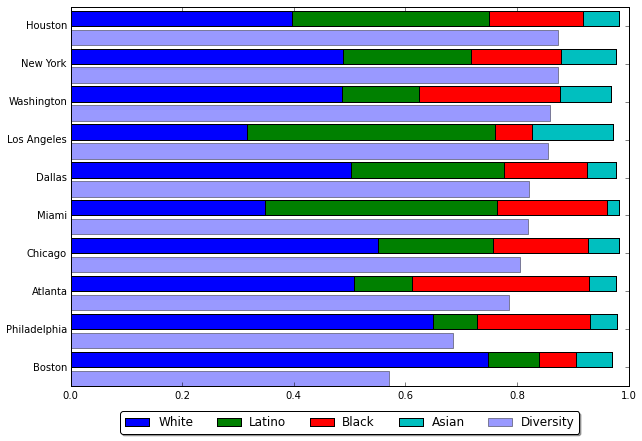

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111)

# y axis locations for diversity and races
y_div = np.arange(len(cities))*2
y_race = (np.arange(len(cities))*2)+1

# diversity bars
pDiversity = ax.barh(y_div, diversity, alpha=0.4)

# stacked horizontal bars
pWhite = ax.barh(y_race, p_white, color='b')
pLatino = ax.barh(y_race, p_latino, color='g', left=p_white)
pBlack = ax.barh(y_race, p_black, color='r', left=p_white+p_latino)
pAsian = ax.barh(y_race, p_asian, color='c', left=p_white+p_latino+p_black)

plt.yticks(y_race, cities)

# legend foo https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
# Shink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.85])

# Put a legend below current axis
ax.legend((pWhite, pLatino, pBlack, pAsian, pDiversity), ('White', 'Latino', 'Black', 'Asian', 'Diversity'),
          loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

plt.show()

# If you want to save it
#fig.savefig('diversity')